In [ ]:
#  === Libraries ===
import matplotlib.pyplot as plt
import os
#text parsing
import re
#math operations
import math
# stemming
from nltk.stem import PorterStemmer
#default values dict
from collections import defaultdict

In [ ]:
# === Loading Files ===
#stopwords loading
def Stopwords_Load(path):
    with open(path, "r", encoding="utf-8") as F:
        return set(F.read().split())

#Word to ID mapping
def Word_Dictionary_Load(Path):
    Word_Dict = {}
    with open(Path, "r") as F:
        for line in F:
            if line.strip() == "":
                break
            Word, Wid = line.strip().split()
            Word_Dict[Word] = int(Wid)
    return Word_Dict

#Forward Index Loading
def Forward_Index_Load(Path):
    Indx = defaultdict(dict) #
    with open(Path, "r") as F:
        for Line in F:
            doc_id, Items = Line.strip().split(": ") #doc id and items split
            for item in Items.split("; "):
                Wid, freq = map(int, item.split(":")) #converting to int
                Indx[doc_id][Wid] = freq
    return Indx

# Loading inverted index
def Inverted_Index_Load(Path):
    Indx = defaultdict(dict)
    with open(Path, "r") as freqs:
        for Line in freqs:
            Wid, items = Line.strip().split(": ") #term id and items split
            for item in items.split("; "): #split doc/freq
                doc_id, freq = item.split(":")
                Indx[int(Wid)][doc_id] = int(freq)
    return Indx

def Queries_Parse(Path):
    #query topics file parsing
    with open(Path, "r", encoding="utf-8") as F:
        content = F.read()
    Queries = {}
    for block in content.strip().split("</top>"):  # Split by query blocks
        if "<num>" in block:
            #query ID extraction
            QID = re.search(r"<num>\s*Number:\s*(\d+)", block).group(1)
            #title extract
            title = re.search(r"<title>\s*(.*?)\n", block).group(1)
            #description extract
            desc = re.search(r"<desc> Description:\s*(.*?)\n\n", block, re.DOTALL).group(1)
            #narrative extract
            narr = re.search(r"<narr> Narrative:\s*(.*)", block, re.DOTALL).group(1).strip()
            Queries[QID] = {"title": title, "desc": desc, "narr": narr}
    return Queries

In [ ]:
# === TF-IDF and Similarity ===
# IDF each term calculation
def IDF_Compute(inv_indx, N):
    return {Wid: math.log(N / len(docs)) for Wid, docs in inv_indx.items()}

 # docs vectors for relevant documents
def Document_Vectors_Build(inv_indx, query_terms, IDF):
    doc_vectors = defaultdict(dict)
    for Wid in query_terms:
        if Wid in inv_indx:
            for doc_id, TF in inv_indx[Wid].items():
                # TF weight
                TF_weight = 0.5 + 0.5 * (TF / max(inv_indx[Wid].values()))
                #TF-IDF weight
                doc_vectors[doc_id][Wid] = TF_weight * IDF[Wid]
    return doc_vectors

#cosine similarity between query and docs
def Cosine_Similarity(query_vec, doc_vectors):
    Qnorm = math.sqrt(sum(v ** 2 for v in query_vec.values()))
    scores = {}
    for Doc_ID, vec in doc_vectors.items():
      #dot product
        dot = sum(query_vec.get(Wid, 0) * vec[Wid] for Wid in vec)
        #doc normalization
        Dnorm = math.sqrt(sum(v ** 2 for v in vec.values()))
        if Qnorm and Dnorm:
          #cosine similarity
            scores[Doc_ID] = dot / (Qnorm * Dnorm)
    return scores

# === Query Processing ===
def Preprocess(text, stopwords, stemmer):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    return [stemmer.stem(w) for w in tokens if w not in stopwords]

# each field with its weight processing
def Query_Process(title_text, desc_text, narr_text, word_dict, idf, inverted_index, stopwords, stemmer):
    weights = {"title": 0.3  , "desc": 0.5, "narr": 0.4}
    query_vec = defaultdict(float)

    for field_text, field_weight in zip([title_text, desc_text, narr_text], [weights['title'], weights['desc'], weights['narr']]):
        tokens = Preprocess(field_text, stopwords, stemmer)
        tf = defaultdict(int)
        for word in tokens:
            if word in word_dict:
                tf[word_dict[word]] += 1
        max_tf = max(tf.values()) if tf else 1
         # TF-IDF weight for query terms calculation
        for wid, freq in tf.items():
            tf_weight = 0.5 + 0.5 * (freq / max_tf)
            query_vec[wid] += tf_weight * idf.get(wid, 0) * field_weight

    doc_vectors = Document_Vectors_Build(inverted_index, query_vec.keys(), idf)
    scores = Cosine_Similarity(query_vec, doc_vectors)
    return scores

In [ ]:
# === Evaluation ===
def Qrels_Load(path):
    Qrels = defaultdict(set)
    with open(path, 'r') as F:
        for line in F:
            parts = line.strip().split()
            if len(parts) == 4 and parts[3] == '1':
                topic, _, doc_id, _ = parts
                Qrels[topic].add(doc_id)
    return Qrels

def Results_Evaluate(Qrels, results, k=10):
    Tot_precision = 0
    Tot_Recall = 0
    count = 0
    for Qid in Qrels:
        # documents (top k) retriving
        relevant = Qrels[Qid]
        retrieved = results.get(Qid, [])[:k]
        # true positives
        Pos_true = len(set(retrieved) & relevant)
        precision = Pos_true / len(retrieved) if retrieved else 0
        recall = Pos_true / len(relevant) if relevant else 0
        Tot_precision += precision
        Tot_Recall += recall
        count += 1
    #calculation of averages
    Avg_precision = Tot_precision / count if count else 0
    Avg_Recall = Tot_Recall / count if count else 0
    return Avg_precision, Avg_Recall




=== Summary Table (Average Precision and Recall) ===
Setting             Average Precision   Average Recall      
------------------------------------------------------------
Title               0.0171              0.0078              
Title+Description   0.0195              0.0087              
Title+Narrative     0.0220              0.0097              


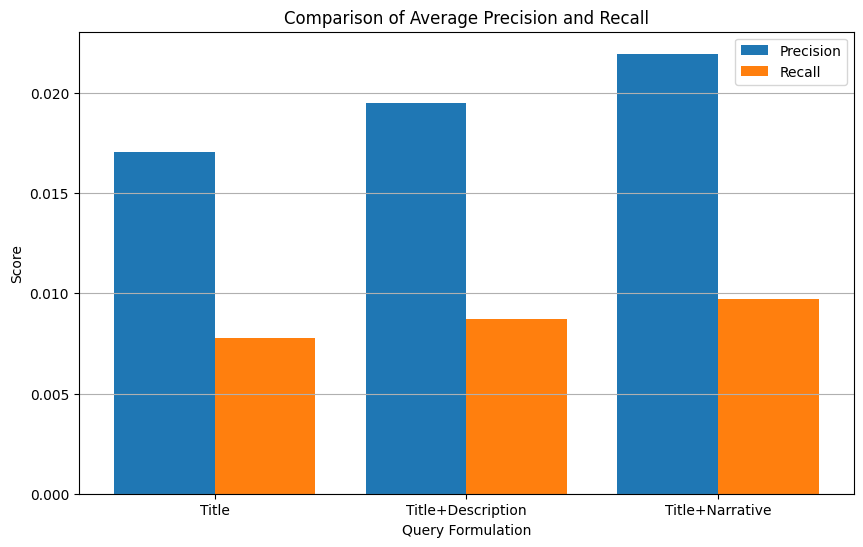

In [ ]:
# === Main Execution ===
def main():
    base = "/content/drive/MyDrive/InfoRetrieval/"
    Path_Stopword = base + "stopwordlist.txt"
    Path_Forw_Inx = base + "forward_index.txt"
    Path_Inv_Inx = base + "inverted_index.txt"
    Parser_output_Path = base + "parser_output.txt"
    Path_topics = base + "topics.txt"
    Path_Qrels = base + "main.qrels"

    stopwords = Stopwords_Load(Path_Stopword)
    stemmer = PorterStemmer()
    word_dict = Word_Dictionary_Load(Parser_output_Path)
    Forward_Index = Forward_Index_Load(Path_Forw_Inx)
    Inverted_Index = Inverted_Index_Load(Path_Inv_Inx)
    IDF = IDF_Compute(Inverted_Index, len(Forward_Index))
    queries = Queries_Parse(Path_topics)
    Qrels = Qrels_Load(Path_Qrels)

    Summary = {}
    #  different query settings testing
    for setting_name in ["Title", "Title+Description", "Title+Narrative"]:
        results = defaultdict(list)
        for qid, parts in queries.items():
          # selecting of fields
            if setting_name == "Title":
                text_title = parts['title']
                text_desc = ""
                text_narr = ""
            elif setting_name == "Title+Description":
                text_title = parts['title']
                text_desc = parts['desc']
                text_narr = ""
            else:  # Title+Narrative
                text_title = parts['title']
                text_desc = ""
                text_narr = parts['narr']

            # query processing and obtaining scores
            scores = Query_Process(text_title, text_desc, text_narr, word_dict, IDF, Inverted_Index, stopwords, stemmer)
            ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            for rank, (doc_id, score) in enumerate(ranked[:1000], 1):
                results[qid].append(doc_id)

        Avg_Prec, Avg_Recall = Results_Evaluate(Qrels, results, k=10)
        Summary[setting_name] = (Avg_Prec, Avg_Recall)

    print("\n=== Summary Table (Average Precision and Recall) ===")
    print(f"{'Setting':<20}{'Average Precision':<20}{'Average Recall':<20}")
    print("-" * 60)
    for setting, (avg_p, avg_r) in Summary.items():
        print(f"{setting:<20}{avg_p:<20.4f}{avg_r:<20.4f}")

    settings = list(Summary.keys())
    avg_precisions = [Summary[s][0] for s in settings]
    avg_recalls = [Summary[s][1] for s in settings]

    x = range(len(settings))

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(x, avg_precisions, width=0.4, label='Precision', align='center')
    plt.bar([i + 0.4 for i in x], avg_recalls, width=0.4, label='Recall', align='center')
    plt.xticks([i + 0.2 for i in x], settings)
    plt.xlabel('Query Formulation')
    plt.ylabel('Score')
    plt.title('Comparison of Average Precision and Recall')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

if __name__ == "__main__":
    main()